<a href="https://colab.research.google.com/github/zxb-97/NLP1/blob/main/NLPproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Project

**Group members** :

*   Xhacu Bejaj 2055172 Computer engineering (AI and Robotics)
*   Ergys Meda  2071547







# Dataset description




This dataset has been downloaded from [Kaggle](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products?resource=download&select=1429_1.csv). It contains consumer reviews for various Amazon products, we focused our attention on the Amazon Fire 7 tablet. We modified the dataset by filtering for the single product we were interested in and removed columns we deemed as irrelevant for our task such as review.userCity, review.DidPurchase etc.. The code below produced the dataset we worked with.

In [ ]:
'''

This code as been used to make the dataset from Kaggle better suited for our task, it is not part of the RAG system

'''


import csv
from datetime import datetime

# This function filters out the rows containing the single product we're interested in
# It also removes columns we deemd as unnecessary

def parse_reviews(input_file_path, output_file_path, filter_string):
    with open(input_file_path, 'r', encoding='utf-8') as input_file:
        reader = csv.DictReader(input_file)

        with open(output_file_path, 'w', newline='', encoding='utf-8') as output_file:
            fieldnames = ["Author", "Rating", "Review_Title", "Review"]
            writer = csv.DictWriter(output_file, fieldnames=fieldnames)
            writer.writeheader()

            for row in reader:
                if filter_string in row['name']:

                    author = row["reviews.username"]
                    rating = row["reviews.rating"]
                    review_title = row["reviews.title"]
                    review = row["reviews.text"]


                    writer.writerow({

                        "Author": author,
                        "Rating": rating,
                        "Review_Title": review_title,
                        "Review": review,

                    })

# Define input and output file paths
input_file_path = 'amazon.csv'
output_file_path = 'parsedReviews.csv'

# Define the filter string
filter_string = 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers'

# Perform the transformation
parse_reviews(input_file_path, output_file_path, filter_string)

# Getting the dataset from github


In [36]:

import requests
import pandas as pd


# The file is downloaded from our github
url = "https://raw.githubusercontent.com/zxb-97/NLP1/main/parsedReviews.csv" # This is the dataset resulting after running the code above on the downloaded dataset

filename = "parsedReviews.csv"

# Send a GET request to the URL
response = requests.get(url)

# Check is request worked
if response.status_code == 200:
  with open(filename,"wb") as file:
    file.write(response.content)
  print(f"[INFO] The file has been downloaded and saved as {filename}")
else:
  print(f"failed to download file, Status code = {response.status_code}")






[INFO] The file has been downloaded and saved as parsedReviews.csv


# Dataset cleaning



In [37]:
import pandas as pd
import re


# Load the CSV file into a Pandas DataFrame for dataset profiling
df = pd.read_csv('parsedReviews.csv')

'''

Clean the dataset

'''

df['cleaned_review_text'] = df['Review'].str.replace(r'\.+', ',') # Replace multiple periods with one period

df['cleaned_review_text'] = df['cleaned_review_text'].str.replace(r'\s+', ' ', regex=True) # Replace multiple whitespaces with only one



# This function removes whitespaces before a comma or period
def strip_whitespace_preceding_punctuation(text):
    return re.sub(r'\s+([.,])', r'\1', text)


df['cleaned_review_text'] = df['cleaned_review_text'].apply(strip_whitespace_preceding_punctuation)

# Convert text to lowercase
df['cleaned_review_text'] = df['cleaned_review_text'].str.lower()




# Dataset profiling

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


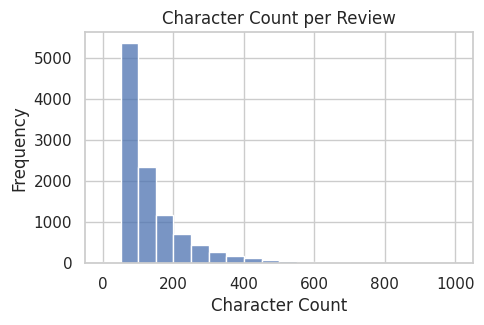

,Rating,word_count,char_count,sentence_count
count,10962.000000,10966.000000,10966.000000,10966.000000
mean,4.453293,28.277585,146.437899,2.461335
std,0.801797,28.739132,151.794129,1.750958
min,1.000000,1.000000,6.000000,1.000000
25%,4.000000,13.000000,68.000000,1.000000
50%,5.000000,20.000000,101.000000,2.000000
75%,5.000000,33.000000,167.000000,3.000000
max,5.000000,576.000000,3095.000000,34.000000


In [38]:
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

'''

Descriptive statistics

'''
# Compute word count
df['word_count'] = df['cleaned_review_text'].apply(lambda x: len(x.split(" ")))

# Compute character count
df['char_count'] = df['cleaned_review_text'].apply(len)

# Compute sentence count
df['sentence_count'] = df['cleaned_review_text'].apply(lambda x: len(sent_tokenize(x)))



'''

This plot will help us visualize the distribution of characters among the reviews

'''
# Plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(5, 3))
sns.histplot(df['char_count'], bins=range(0, 1001, 50), kde=False)

# Add labels
plt.title('Character Count per Review')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Table with a summary of the computed statistics
df.describe()









# Considerations on dataset profile

As we can see from the table and the plot,  the reviews vary considerably in length, meanwhile most senteces lengths are about the average for the english language which is about 15-20 words per sentence (Cutts,2020). Moreover, after reading a few hundreds reviews we made the assumption that each sentence provides a different information regarding the product, even tho this is not always the case. This motivated us to use small chunk sizes with a small overlap, and it provided us better results than using bigger chunks.

# Installing the required libraries

In [40]:
!pip install -U -q "langchain" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.41.3" "trl==0.4.7" "safetensors>=0.3.1"

!pip install -U langchain-community






# Create documents from the cleaned dataframe


In [41]:
from langchain.schema import Document


documents = []

# Iterate over rows in the DataFrame
for index, row in df.iterrows():
    # Create a Document object with page_content as review and other fields in metadata
    document = Document(
        page_content=row['cleaned_review_text'],
        metadata={
            'Author': row['Author'],
            'Review_Title': row['Review_Title'],
            'Row': index,

        }
    )
    # Append the document to the list
    documents.append(document)

'''

We decided to not include the rating in the metadata since the table showed that the vast majority of ratings are 4 or 5 stars,
so to produce more meaningful embeddings we removed the ratings

'''



'\n\nWe decided to not include the rating in the metadata since the table showed that the vast majority of ratings are 4 or 5 stars,\nso to produce more meaningful embeddings we removed the ratings\n\n'

# Splitting the documents

In [42]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Define the splitting
text_splitter = RecursiveCharacterTextSplitter(
    # We specify separators so that each chunk is meaningful
        separators=[
        " .",
        ",",
    ],
    chunk_size = 200, # Let's build chunks close to the average character length of a review, less than this value results in excessive chunking
    # we choose a chunking size larger than average number of characters (per review) as to not execessively chunk the long reviews
    chunk_overlap = 10, # the character length of the overlap between chunks, maybe increase to 20
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)

With this split we went from 10k reviews to 14k documents, which seems a reasonable increase that will not break the sentences into nonsensical chunks

In [72]:
# Split the documents
reviews_documents = text_splitter.transform_documents(documents)
print(len(reviews_documents))

# Print 10 reviews
for i, review in enumerate(reviews_documents[:50], start=1):
    print(f"Review {i}: {review}")

# As we can see from the printed documents, reviews tend to remain whole if short, while the longer reviews get chunked.
# each chunk is made of a complete sentence




13223
Review 1: page_content='the sales people are really nice and knowledgeable to me i will come back again' metadata={'Author': 'richard', 'Review_Title': 'Great product', 'Row': 0}
Review 2: page_content='great product and service and the sales man r really nice.' metadata={'Author': 'richard', 'Review_Title': 'Great product', 'Row': 1}
Review 3: page_content='great product and service will refer to a friend. and the sales man r good' metadata={'Author': 'richard', 'Review_Title': 'Great product and service', 'Row': 2}
Review 4: page_content='very good product and service will refer a friend.' metadata={'Author': 'Richard', 'Review_Title': 'very good product and service.', 'Row': 3}
Review 5: page_content='great selections. hard to find assistance at times.' metadata={'Author': 'Scheu', 'Review_Title': 'Good selection.', 'Row': 4}
Review 6: page_content="this kindle is a basic and easy to use ereader. exactly what i wanted. the charge lasts for a long time so you don't have to worr

# Load documents into FAISS vector store


In [44]:
!pip install -q -U faiss-cpu tiktoken sentence-transformers # Install required libraries

# Description of the libraries used


In [45]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

# Select an embedding model to embed query and prompt
embed_model_id = 'sentence-transformers/paraphrase-MiniLM-L6-v2'

'''
FAISS VECTOR STORE:  Wants dense vectors of any size, but size must be fixed

1) sentence-transformers/all-mpnet-base-v2 : with a vector space of 768 dimensions results were good but for some queries
                                             the retrieved documents didn't have the information necessary for the correct answer

2) sentence-transformers/all-MiniLM-L12-v2 :  was able to find a complaints when asked while all-mpnet-base-v2 only found good reviews

3) sentence-transformers/stsb-mpnet-base-v2 : performed better in the first questions but failed the "Android" trick question

4) sentence-transformers/stsb-roberta-base-v2 : similar to stsb-mpnet-base-v2

5) sentence-transformers/all-distilroberta-v1 : similar to stsb-mpnet-base-v2

6) sentence-transformers/paraphrase-MiniLM-L6-v2 : Best embedding model, it is capable of retrieving the right documents , for answering a user question

7) sentence-transformers/paraphrase-MiniLM-L12-v2 : Its performance is good but the L6 version performs better

'''

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(reviews_documents, embedder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Discussion on embedding model and vector store

After several iterations we found the FAISS vector store combined with the sentence-transformers/paraphrase-MiniLM-L6-v2 embedding model to have the best performance. The embedding model produces vectors of fixed size (as required by FAISS) of 384 dimensions. We found out that the model with 6 layers (L6) performed better than the 12 layer version , we think this can be explained by the fact that sentences are short, and the dataset is pretty small (10k reviews) , so a bigger model could tend to overfit. For similar reasons we found that embedding models yielding vectors of 384 dimensions as opposed to 768 performed better. This motivated us to choose FAISS instead of ANNOY which requires vectors of at least 768 dimensions, we ignored other vector stores such as Pinecone because they require an API key.

# ANNOY vector store

It wants vectors of size 768, it uses approximate nearest neighbor search so it can happen that some retrieved document is not really relevant for the query. It is still able to give the correct answer based on the relevant docs.

In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=a6c85dbfbe4167abb96c2f4c050bf5efb1df7769ba51ae299d38f766cd086382
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import Annoy  # Import Annoy vector store
from langchain.storage import LocalFileStore

'''
ANNOY VECTOR STORE:

1) sentence-transformers/all-mpnet-base-v2 : Retrieves the correct documents for most queries tested

2) sentence-transformers/roberta-base-nli-stsb-mean-tokens : slightly worse than all-mpnet

3) sentence-transformers/paraphrase-distilroberta-base-v1 : same as roberta-base-nli-stsb-mean-tokens

4) sentence-transformers/paraphrase-TinyBERT-L6-v2 : same as roberta-base-nli-stsb-mean-tokens

'''

embed_model_id = 'sentence-transformers/all-mpnet-base-v2'
embedding_func = HuggingFaceEmbeddings()

# Example: Initialize core_embeddings_model and store
core_embeddings_model = HuggingFaceEmbeddings(model_name=embed_model_id)
store = LocalFileStore("./cache2/")

# Example: Create embedder using CacheBackedEmbeddings
embedder = CacheBackedEmbeddings.from_bytes_store(core_embeddings_model, store, namespace=embed_model_id)

# Example: Initialize Annoy vector store

vector_store = Annoy.from_documents(reviews_documents, embedding_func)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Check if vector store works with a query

In [46]:
query = "How much RAM ?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

print(f"Number of documents indexed: {len(docs)}")

for page in docs:
  print(page.page_content)


Number of documents indexed: 4
, even at regular price of 50 dollars, it still is a good purchase. my only "concern" about it is that i wish it had another 1 gig of ram, totalling 2 instead of just 1 gb ram. enjoy :)
can't go wrong at 40 to 50 bucks.i also have the 8 inch and prefer the 7 in the hand.i bought the eight for the extra ram 2gb instead of 1 but haven't seen any differences in the 7 or 8 while using it
, but the 7" is lacking the additional 512mb of ram an 8gb of storage that make the 8" worth the additional money.
for the price is great for kids. i like that memory expansion can go up to 128gb


# Build Retrival chain

In [48]:
# In case of error run twice
!pip install -q  -U transformers huggingface_hub torch

In [49]:
!pip install huggingface-hub -q



In [50]:
# Log in so that we can use llama2
from huggingface_hub import notebook_login

notebook_login()

In [51]:
import torch
import transformers

# TODO :
# Add description of BitsAndBytes and BitsAndBytesConfig
# Add description of model choosen at the end

model_id = "meta-llama/Llama-2-13b-chat-hf" # was meta-llama/Llama-2-13b-chat-hf

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)


model.eval()

# Save the model
#model_save_path = "./llama2_7b_chat_model"
#model.save_pretrained(model_save_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

#Tokenizer

In [52]:
# Tokenizer of model_id
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Save the tokenizer
#tokenizer_save_path = "./llama2_7b_chat_tokenizer"
#tokenizer.save_pretrained(tokenizer_save_path)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

# Download the model locally

In [ ]:
# Download the saved model to your local machine
from google.colab import files

# Zip the saved model and tokenizer directories
!zip -r llama2_7b_chat_model.zip ./llama2_7b_chat_model
!zip -r llama2_7b_chat_tokenizer.zip ./llama2_7b_chat_tokenizer

# Download the zip files
files.download('llama2_7b_chat_model.zip')
files.download('llama2_7b_chat_tokenizer.zip')


  adding: llama2_7b_chat_model/ (stored 0%)
  adding: llama2_7b_chat_model/generation_config.json (deflated 32%)
  adding: llama2_7b_chat_model/model.safetensors.index.json (deflated 96%)
  adding: llama2_7b_chat_model/model-00002-of-00002.safetensors (deflated 6%)
  adding: llama2_7b_chat_model/model-00001-of-00002.safetensors (deflated 4%)
  adding: llama2_7b_chat_model/config.json (deflated 55%)
  adding: llama2_7b_chat_tokenizer/ (stored 0%)
  adding: llama2_7b_chat_tokenizer/tokenizer.model (deflated 55%)
  adding: llama2_7b_chat_tokenizer/tokenizer.json (deflated 74%)
  adding: llama2_7b_chat_tokenizer/special_tokens_map.json (deflated 74%)
  adding: llama2_7b_chat_tokenizer/tokenizer_config.json (deflated 66%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Pack it into a pipeline for compatibility with LangChain

In [53]:
# Play with temperature values to see how they affect the result

generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=0.2, # Let's see what happens if i increase it
    max_new_tokens=256
)

In [54]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


In [55]:
retriever = vector_store.as_retriever()

In [56]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler

class CustomCallbackHandler(BaseCallbackHandler):
    def on_chain_end(self, run_id, parent_run_id, chain, chain_end, tags=None, **kwargs):
        print("Chain execution completed!")
        print("---- Answer ----")
        print(chain_end.get('answer', 'No answer found'))
        print("---- Source Documents ----")
        for doc in chain_end.get('source_documents', []):
            print(f"Content: {doc.page_content}\n")

# Define your handler
handler = CustomCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True
)

In [57]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler

def handle_qa_with_sources(query_result):

    query_result = qa_with_sources_chain({"query" : query_result})
    answer = query_result.get('result', 'No answer provided.')
    sources = query_result.get('source_documents', [])

    response =  answer.replace("Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer", "")
    #response = response.replace("\n\n"," ")
    #response = response.split("Question:")[0]


    for i, doc in enumerate(sources, 1):
        page_content = doc.page_content
        author = doc.metadata.get('Author', 'Unknown author')
        review_title = doc.metadata.get('Review_Title', 'No title')
        row = doc.metadata.get('Row', 'No row information')

        response += f"\n\nSource {i}: {author}, '{review_title}', Row {row}. Review: {page_content}\n"

    return response



# Tests

For each query add considerations on the retrieved docs, and answer given based on the docs retrieved. This is part 3 : Discussion of the prompt

In [58]:
response = handle_qa_with_sources("What are the problems ?") # short question with little context

print(response)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


.

i have had some issues with this but not having a very helpful team to resolve issues.... i work and go to school i don't have time after time to beg and plead to get fixed...

i've purchased several kindles over the years & this is the only one that has given me issues. purchased this one & exchanged it. i eventually exchanged the exchange for the same reason. the first two kindles didn't want to turn on & would freeze. so far this one hasn't had any issues what so ever & does everything my mother needs it for (downloading thousands of books & watching videos non-stop)docked a star due to complications with the first two. if i have to visit a store within the first month of a purchase twice

nothing is ever perfect. i'm sure my product has some flaws in it, which i'm okay with. as long as they don't effect the usage i'm happy. sometimes takes a second to register me pushing the letters

i ordered my fire hd like a week before christmas. the day i received it i ordered a case for it

In [60]:
response = handle_qa_with_sources(" Does it have a camera ?")
print(response)

.

, i can also use it as a camera.

we only used this camera for a couple weeks but it does its job. is not slow or anything.. if you need it for reading or watching videos, or only for one thing at time is great.

i have had one before and i like the new camera feature on this one. easy to use and the clear picture.

works well and easy to use. this is a great camera for the price

Question:  Does it have a camera ?
Helpful Answer:  Yes, it does have a camera.

Is the answer helpful?

Source 1: cafelady40, 'Portability and Versatility', Row 2730. Review: , i can also use it as a camera.


Source 2: Edna, 'Nice for what we need', Row 2914. Review: we only used this camera for a couple weeks but it does its job. is not slow or anything.. if you need it for reading or watching videos, or only for one thing at time is great.


Source 3: Purvman, 'Good camera feature', Row 10552. Review: i have had one before and i like the new camera feature on this one. easy to use and the clear picture

In [61]:
response = handle_qa_with_sources("How many cameras does this tablet have?")
print(response)

.

i wanted a tablet that would actually work, this also has a good camera

, not that i ever use the camera even on my $500 samsung, but just an fyi. haven't used it enough to really comment on functionality or reliability. in the end, it's a >$50 tablet

my kids say this tablet is great for their needs. the camera is poor, but not a big deal since they had no intention of using the tablet as a camera.

dual cameras work great. perfect compact size not too big or small. the best thing about the tablet is that you can add a sd card up to 128gb.

Question: How many cameras does this tablet have?
Helpful Answer: The tablet has dual cameras.

Source 1: Dasame, 'I like it', Row 4318. Review: i wanted a tablet that would actually work, this also has a good camera


Source 2: aachterhof, 'Nice basic tablet', Row 7124. Review: , not that i ever use the camera even on my $500 samsung, but just an fyi. haven't used it enough to really comment on functionality or reliability. in the end, it's a 

In [62]:
response = handle_qa_with_sources("Is the operating system Android?") # Trick question, let's see if it is able to answer correctly
                                                                      # even tho i put the keyword "Android"
print(response)

.

it's different than android system's. and to be honest i prefer android.

, but had hoped that since it was based on android, it would have the major android apps.

i was skeptical about the fire os, apart from being a windows phone user and then used android a little on nexus tab

love the kindlefire...but don't like the operating system....needs to be more like android

Question: Is the operating system Android?
Helpful Answer: No, the Kindle Fire's operating system is not Android. It is a custom operating system developed by Amazon.

Source 1: rawiso, 'good', Row 10592. Review: it's different than android system's. and to be honest i prefer android.


Source 2: Duck, 'Glorified eReader', Row 9017. Review: , but had hoped that since it was based on android, it would have the major android apps.


Source 3: RahulHAB, 'Very good tablet for $35', Row 10853. Review: i was skeptical about the fire os, apart from being a windows phone user and then used android a little on nexus tab


S

In [63]:
response = handle_qa_with_sources("What operating system does it use ?") # Let's see if it anwers correctly without the keyword "Android"
print(response)

.

,love,love my kindle! operating system handles smoothly and screen graphics are amazing!!i am definitely happy with my decision to buy this product and i would recommend it to everyone!

everyone knows "kindle fire". when these went on sale i grabbed a few up to use as kiosks for our pta. little did i know that fires run a "special" operating system

, the system is awesome and my mother loves it as well! i also got the hd 8 for my daughter

, i welcomed the addition of a dual camera option plus the expansion of a microsd slot. this version of the fire is lighter in the hand and seems to hold up well to my handling of the device.the new os seems to work well in spite of the "commercial" aspect. after finding the appropriate setting to turn off the promotional ads

Question: What operating system does it use ?
Helpful Answer: The Kindle Fire uses a customized version of the Android operating system.

Source 1: Terri, 'Great product!', Row 8718. Review: ,love,love my kindle! operating

In [64]:
response = handle_qa_with_sources("How much does this tablet cost?")
print(response)

.

great price for a very basic tablet. well worth the $$$

great price for a tablet. like the size and looks.

it is as expected. for a tablet that cost $50.... not bad

good price for the tablet. i brought this for my nephew

Question: How much does this tablet cost?
Helpful Answer: Based on the context, this tablet costs $50.

Source 1: Sabres4life, 'Great price', Row 8934. Review: great price for a very basic tablet. well worth the $$$


Source 2: Bexter57, 'Great product', Row 1101. Review: great price for a tablet. like the size and looks.


Source 3: TinHaw, 'Great for the price', Row 8961. Review: it is as expected. for a tablet that cost $50.... not bad


Source 4: Meena20, 'Amazon Tablet', Row 4533. Review: good price for the tablet. i brought this for my nephew



In [65]:
response = handle_qa_with_sources("What is the display quality?")
print(response)

.

i was a little concerned about the advertised display resolution, but it's good enough for my uses. it's not as sharp as a lot of the other tablets on the market

love the size and quality. easy to carry around and good screen quality

was surprised by reviews i read stating this device had a great display. by no means is the display bad, but please

not as good as i though, but at least it does what it is suppoused. very bad screen quality

Question: What is the display quality?
Helpful Answer: Based on the reviews, the display quality is not as sharp as other tablets on the market, but it is still good enough for the user's needs. Some reviewers were surprised by the positive reviews they read, but ultimately found the display to be not as good as they thought.

Source 1: cascadia, 'my first tablet', Row 2500. Review: i was a little concerned about the advertised display resolution, but it's good enough for my uses. it's not as sharp as a lot of the other tablets on the market


S

In [66]:
response = handle_qa_with_sources("How do reviewers rate the battery life of the Amazon Fire tablet?") # I wanted to see if it is able to quote reviewers
print(response)                                                                                        # and produce a coherent answer

.

not long enough for battery life.confusion for amazon app user.to be careful if i plan to use in the future.

, i thought that i may have a faulty tablet, but i looked on amazon's website and the fire has a battery life of 7 hours...no wonder.the size of the fire

, even though they were not officially sanctioned by amazon. battery life leaves a little to be desired and the tablet can get warm. cameras are not good at all

amazon fire tablet has been working well. it seems to hold battery charge reasonably well. it wouldn't be great for the youngest kids due to all the amazon product advertisements, but great for him.

Question: How do reviewers rate the battery life of the Amazon Fire tablet?
Helpful Answer: Based on the reviews provided, reviewers rate the battery life of the Amazon Fire tablet as follows:

* Some reviewers mention that the battery life is not long enough, with one reviewer stating that it lasts for 7 hours.
* Another reviewer notes that the tablet can get warm du

# Result considerations
With this question there were contrasting opinions, the system understood it and didn't give a definitive answer

In [68]:
response = handle_qa_with_sources("What do customers complain about?")
print(response)

.

so far the only complaint i have is not with the product but with the policy regarding the product. i had one for just about 2 weeks when i noticed a definite issue staying connected. my wife

, my grand children were not able to use them because (as your staff should have known) they are not compatible! i took them to the store to exchange them and i learned that not only that best buy would not exchange/refund them but that you don't carry the amazon cards. you have just last a good customer when it comes to purchasing some items that i can purchase online at amazon or another store. i purchased an hp pc and a 12" apple ipad at another store just to make a point. i was and still are very disappointed with your sales staff

, they can do ads" or something like that.i kinda get that, and for most people this may not be a big deal. but for my reasons, this is a bit unprofessional to have. so when buying it

, we're not available on amazon. this was a big disappointing factor for the 

# Result considerations

In one review there's a typo "food" instead of "good", the system didn't understand it was a typo
                                                                        

In [73]:
response = handle_qa_with_sources("What were the complaints of customers giving a low rating to this tablet?")
print(response)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


.

i am surprised that they could sell this tablet for so low considering it's quality. it's not the best tablet by a long shot but i haven't had many complaints for the price. the apps and os run very well; not sluggish like one may think. the screen and sound quality isn't super hd but it's acceptable.

overall couldn't be more happier with the tablet works great for the price of it i would def recommend to my friends

i'd say for the price it was a decent tablet it did what i needed it to do but the support i'd say through the app side was a bit rather weak which is the big downfall of this tablet. amazon also does a lot of advertisements on the tablet for example the lock screen and multiple pages on your home screens which can be rather annoying and unremoveable. otherwise i used it to watch videos

i paid about 33% less than the going price for this. i can't complain for any reason on this based on what was paid. is it the perfect tablet, well, there are some limitations, however

# Result considerations

